In [1]:
from doe_modules.simulation import Test4

In [13]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from doe_modules.preferences import kwarg_savefig

In [4]:
from itertools import product

In [5]:
edges = np.array(list(map(list, product([-1, 0, 1], repeat=10))))

In [7]:
edges.shape

(59049, 10)

In [8]:
59048 / 2

29524.0

In [9]:
from doe_modules.design import CLOO

In [10]:
# models = [Prototype(v, model_id=i) for i, v in enumerate(edges)]
models = [Test4(v, model_id=i) for i, v in enumerate(edges)]

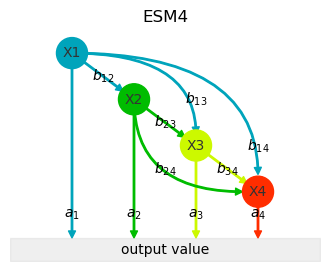

In [16]:
fig, ax = plt.subplots(figsize=(4, 3))
model = Test4(edges[-1], model_id="")
model.plot(ax)

datdot = pd.DataFrame({
    "h": [2, 4, 6, 8],
    "v": [9, 7, 5, 3]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: (datdot.h[2], datdot.v[1]),
    14: (datdot.h[3], datdot.v[2]),
    23: (datdot.h[1:3].mean(), datdot.v[1:3].mean()),
    24: (datdot.h[1:3].mean(), datdot.v[2:4].mean()),
    34: (datdot.h[2:4].mean(), datdot.v[2:4].mean()),
}

for i in [1, 2, 3, 4]:
    ax.text(
        datdot.h[i - 1], 2,
        r"$a_{" + str(i) + "}$",
        ha="center", va="center", size=10
    )

for k, b in b_pos.items():
    ax.text(
        *b_pos[k], r"$b_{" + str(k) + "}$",
        ha="center", va="center", size=10
    )

ax.set(title=model.name)

fig.savefig(f"/home/jovyan/out/test4_models", **kwarg_savefig)

In [281]:
ap = lambda c: dict(
    shrink=0, width=1, headwidth=5, 
    headlength=5, connectionstyle="arc3",
    facecolor=c, edgecolor=c,
)

ap2 = lambda c: dict(
    arrowstyle="|-|", connectionstyle="arc3",
    facecolor=c, edgecolor=c,
    linewidth=2, mutation_scale=4,
)

angleA = lambda n: [0, -90, 0, -45][n - 1]
angleB = lambda n: [90, 180, 105, 120][n - 1]

app = lambda n, c: dict(
    shrink=0, width=1, headwidth=5, 
    headlength=5, 
    connectionstyle=f"angle3, angleA={angleA(n)}, angleB={angleB(n)}",
    facecolor=c, edgecolor=c,
)

apn = lambda n, c: dict(
    arrowstyle="|-|", connectionstyle=f"angle3, angleA={angleA(n)}, angleB={angleB(n)}",
    facecolor=c, edgecolor=c,
    linewidth=2, mutation_scale=4,
)

arrconf=dict(ha="center", va="center", zorder=-10)

edge_pos = {
    12: ([datdot.h[1] - .5 / np.sqrt(2), datdot.v[1] + .5 / np.sqrt(2)], [datdot.h[0], datdot.v[0]]),
    13: ([datdot.h[2], datdot.v[2] + .5], [datdot.h[0], datdot.v[0]]),
    14: ([datdot.h[3], datdot.v[3] + .75], [datdot.h[0], datdot.v[0]]),
    23: ([datdot.h[2] - .5 / np.sqrt(2), datdot.v[2] + .5 / np.sqrt(2)], [datdot.h[1], datdot.v[1]]),
    24: ([datdot.h[3] - .5, datdot.v[3]], [datdot.h[1], datdot.v[1]]),
    34: ([datdot.h[3] - .5 / np.sqrt(2), datdot.v[3] + .5 / np.sqrt(2)], [datdot.h[2], datdot.v[2]]),
}

In [307]:
datdot = pd.DataFrame({
    "h": [2, 4, 6, 8],
    "v": [9, 7, 5, 3],
    "c": ["r", "r", ".9", "r"]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: ((datdot.h[2] + datdot.h[1:3].mean()) / 2, (datdot.v[1] + datdot.v[1:3].mean()) / 2),
    14: (datdot.h[3], datdot.v[2]),
}

a_aps = {
    2: ap("r"),
    4: ap2("r")
}

b_aps = {
    12: ap("r"),
    13: app(1, ".9"),
    14: apn(1, "r"),
    23: ap2(".9"),
}

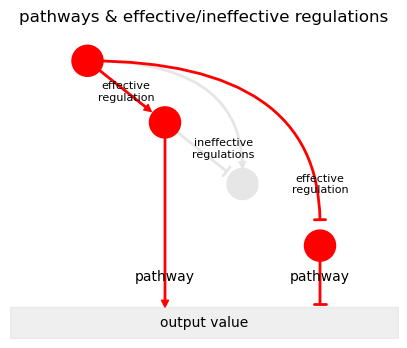

In [308]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.annotate("", [datdot.h[2 - 1], 1], [datdot.h[2 - 1], datdot.v[2 - 1]], arrowprops=a_aps[2], **arrconf)
ax.annotate("", [datdot.h[4 - 1], 1], [datdot.h[4 - 1], datdot.v[4 - 1]], arrowprops=a_aps[4], **arrconf)

ax.text(datdot.h[2 - 1], 2, "pathway", ha="center", va="center", size=10)
ax.text(datdot.h[4 - 1], 2, "pathway", ha="center", va="center", size=10)

ax.annotate("", *edge_pos[12], arrowprops=b_aps[12], **arrconf)
ax.annotate("", *edge_pos[13], arrowprops=b_aps[13], **arrconf)
ax.annotate("", *edge_pos[14], arrowprops=b_aps[14], **arrconf)
ax.annotate("", *edge_pos[23], arrowprops=b_aps[23], **arrconf)

ax.text(*b_pos[12], "effective\nregulation", ha="center", va="center", size=8)
ax.text(*b_pos[13], "ineffective\nregulations", ha="center", va="top", size=8)
ax.text(*b_pos[14], "effective\nregulation", ha="center", va="center", size=8)

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

ax.set_title("pathways & effective/ineffective regulations")

fig.savefig(f"/home/jovyan/out/feat_path_reg", **kwarg_savefig)

In [471]:
datdot = pd.DataFrame({
    "h": [2, 4, 6, 8],
    "v": [9, 7, 5, 3],
    "c": [".9", ".9", ".9", ".9"]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: (datdot.h[2], datdot.v[1]),
    14: (datdot.h[3], datdot.v[2]),
    23: (datdot.h[1:3].mean(), datdot.v[1:3].mean()),
    24: (datdot.h[1:3].mean(), datdot.v[2:4].mean()),
    34: (datdot.h[2:4].mean(), datdot.v[2:4].mean()),
}

a_aps = {
    1: ap(".9"),
    2: ap(".9"),
    3: ap2(".9"),
    4: ap2(".9")
}

b_aps = {
    12: ap(".9"),
    13: app(1, ".9"),
    14: apn(1, ".9"),
    23: ap2(".9"),
    24: app(2, ".9"),
}

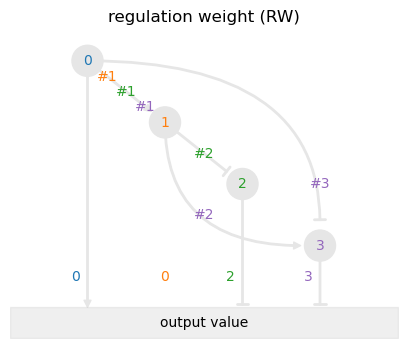

In [472]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.annotate("", [datdot.h[1 - 1], 1], [datdot.h[1 - 1], datdot.v[1 - 1]], arrowprops=a_aps[1], **arrconf)
ax.annotate("", [datdot.h[3 - 1], 1], [datdot.h[3 - 1], datdot.v[3 - 1]], arrowprops=a_aps[3], **arrconf)
ax.annotate("", [datdot.h[4 - 1], 1], [datdot.h[4 - 1], datdot.v[4 - 1]], arrowprops=a_aps[4], **arrconf)

ax.text(datdot.h[1 - 1], datdot.v[1 - 1], "0", ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[2 - 1], datdot.v[2 - 1], "1", ha="center", va="center", size=10, c="C1")
ax.text(datdot.h[3 - 1], datdot.v[3 - 1], "2", ha="center", va="center", size=10, c="C2")
ax.text(datdot.h[4 - 1], datdot.v[4 - 1], "3", ha="center", va="center", size=10, c="C4")

ax.text(datdot.h[1 - 1] -.3, 2, "0", ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[2 - 1], 2, "0", ha="center", va="center", size=10, c="C1")
ax.text(datdot.h[3 - 1] -.3, 2, "2", ha="center", va="center", size=10, c="C2")
ax.text(datdot.h[4 - 1] -.3, 2, "3", ha="center", va="center", size=10, c="C4")

ax.annotate("", *edge_pos[12], arrowprops=b_aps[12], **arrconf)
ax.annotate("", *edge_pos[14], arrowprops=b_aps[14], **arrconf)
ax.annotate("", *edge_pos[23], arrowprops=b_aps[23], **arrconf)
ax.annotate("", *edge_pos[24], arrowprops=b_aps[24], **arrconf)

ax.text(*(np.array(b_pos[12])+np.array([-.5, .5])), "#1", ha="center", va="center", size=10, c="C1")
ax.text(*(np.array(b_pos[12])+np.array([-0, 0])), "#1", ha="center", va="center", size=10, c="C2")
ax.text(*(np.array(b_pos[12])+np.array([.5, -.5])), "#1", ha="center", va="center", size=10, c="C4")
ax.text(*b_pos[14], "#3", ha="center", va="center", size=10, c="C4")
ax.text(*b_pos[23], "#2", ha="center", va="center", size=10, c="C2")
ax.text(*b_pos[24], "#2", ha="center", va="center", size=10, c="C4")

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

ax.set_title("regulation weight (RW)")

fig.savefig(f"/home/jovyan/out/feat_reg_weight", **kwarg_savefig)

In [507]:
datdot = pd.DataFrame({
    "h": [2, 4, 6, 8],
    "v": [9, 7, 5, 3],
    "c": ["r", "r", ".9", "r"]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: (datdot.h[2], datdot.v[1]),
    14: (datdot.h[3], datdot.v[2]),
    23: (datdot.h[1:3].mean(), datdot.v[1:3].mean()),
    24: (datdot.h[1:3].mean(), datdot.v[2:4].mean()),
    34: (datdot.h[2:4].mean(), datdot.v[2:4].mean()),
}

a_aps = {
    1: ap(".9"),
    2: ap(".9"),
    3: ap2(".9"),
    4: ap2("r")
}

b_aps = {
    12: ap(".9"),
    13: app(1, ".9"),
    14: apn(1, "r"),
    23: ap2(".9"),
    24: app(2, "r"),
}

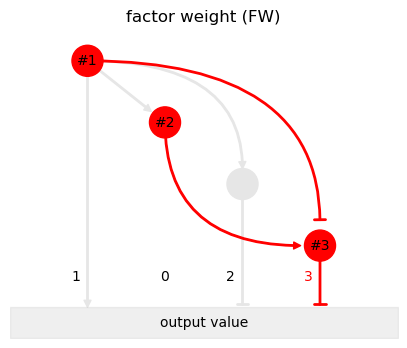

In [508]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.annotate("", [datdot.h[1 - 1], 1], [datdot.h[1 - 1], datdot.v[1 - 1]], arrowprops=a_aps[1], **arrconf)
ax.annotate("", [datdot.h[3 - 1], 1], [datdot.h[3 - 1], datdot.v[3 - 1]], arrowprops=a_aps[3], **arrconf)
ax.annotate("", [datdot.h[4 - 1], 1], [datdot.h[4 - 1], datdot.v[4 - 1]], arrowprops=a_aps[4], **arrconf)

ax.text(datdot.h[1 - 1], datdot.v[1 - 1], "#1", ha="center", va="center", size=10)
ax.text(datdot.h[2 - 1], datdot.v[2 - 1], "#2", ha="center", va="center", size=10)
ax.text(datdot.h[3 - 1], datdot.v[3 - 1], "", ha="center", va="center", size=10)
ax.text(datdot.h[4 - 1], datdot.v[4 - 1], "#3", ha="center", va="center", size=10)

ax.text(datdot.h[1 - 1] -.3, 2, "1", ha="center", va="center", size=10)
ax.text(datdot.h[2 - 1], 2, "0", ha="center", va="center", size=10)
ax.text(datdot.h[3 - 1] -.3, 2, "2", ha="center", va="center", size=10)
ax.text(datdot.h[4 - 1] -.3, 2, "3", ha="center", va="center", size=10, c="r")

ax.annotate("", *edge_pos[12], arrowprops=b_aps[12], **arrconf)
ax.annotate("", *edge_pos[13], arrowprops=b_aps[13], **arrconf)
ax.annotate("", *edge_pos[14], arrowprops=b_aps[14], **arrconf)
ax.annotate("", *edge_pos[24], arrowprops=b_aps[24], **arrconf)

ax.text(*b_pos[12], "", ha="center", va="center", size=10)
ax.text(*b_pos[13], "", ha="center", va="center", size=10)
ax.text(*b_pos[14], "", ha="center", va="center", size=10)
ax.text(*b_pos[24], "", ha="center", va="center", size=10)

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

ax.set_title("factor weight (FW)")

fig.savefig(f"/home/jovyan/out/feat_factor_weight", **kwarg_savefig)

In [313]:
datdot = pd.DataFrame({
    "h": [2, 4, 6, 8],
    "v": [9, 7, 5, 3],
    "c": [".9", ".9", ".9", ".9"]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: (datdot.h[2], datdot.v[1]),
    14: (datdot.h[3], datdot.v[2]),
    23: (datdot.h[1:3].mean(), datdot.v[1:3].mean()),
    24: (datdot.h[1:3].mean(), datdot.v[2:4].mean()),
    34: (datdot.h[2:4].mean(), datdot.v[2:4].mean()),
}

a_aps = {
    1: ap("C0"),
    2: ap(".9"),
    3: ap("C1"),
    4: ap2("C2")
}

b_aps = {
    12: ap("C2"),
    13: app(1, "C1"),
    14: apn(1, "C4"),
    23: ap2(".9"),
    24: app(2, "C2"),
}

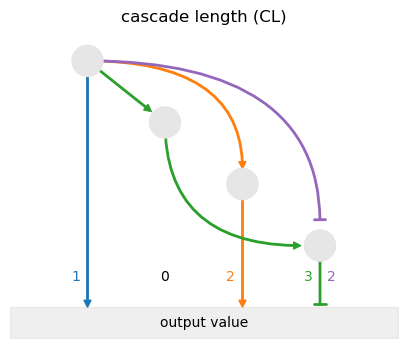

In [314]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.annotate("", [datdot.h[1 - 1], 1], [datdot.h[1 - 1], datdot.v[1 - 1]], arrowprops=a_aps[1], **arrconf)
ax.annotate("", [datdot.h[3 - 1], 1], [datdot.h[3 - 1], datdot.v[3 - 1]], arrowprops=a_aps[3], **arrconf)
ax.annotate("", [datdot.h[4 - 1], 1], [datdot.h[4 - 1], datdot.v[4 - 1]], arrowprops=a_aps[4], **arrconf)

ax.text(datdot.h[1 - 1], datdot.v[1 - 1], "", ha="center", va="center", size=10)
ax.text(datdot.h[2 - 1], datdot.v[2 - 1], "", ha="center", va="center", size=10)
ax.text(datdot.h[3 - 1], datdot.v[3 - 1], "", ha="center", va="center", size=10)
ax.text(datdot.h[4 - 1], datdot.v[4 - 1], "", ha="center", va="center", size=10)

ax.text(datdot.h[1 - 1] -.3, 2, "1", ha="center", va="center", size=10, c="C0")
ax.text(datdot.h[2 - 1], 2, "0", ha="center", va="center", size=10)
ax.text(datdot.h[3 - 1] -.3, 2, "2", ha="center", va="center", size=10, c="C1")
ax.text(datdot.h[4 - 1] -.3, 2, "3", ha="center", va="center", size=10, c="C2")
ax.text(datdot.h[4 - 1] +.3, 2, "2", ha="center", va="center", size=10, c="C4")

ax.annotate("", *edge_pos[12], arrowprops=b_aps[12], **arrconf)
ax.annotate("", *edge_pos[13], arrowprops=b_aps[13], **arrconf)
ax.annotate("", *edge_pos[14], arrowprops=b_aps[14], **arrconf)
ax.annotate("", *edge_pos[24], arrowprops=b_aps[24], **arrconf)

ax.text(*b_pos[12], "", ha="center", va="center", size=10)
ax.text(*b_pos[13], "", ha="center", va="center", size=10)
ax.text(*b_pos[14], "", ha="center", va="center", size=10)
ax.text(*b_pos[24], "", ha="center", va="center", size=8)

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

ax.set_title("cascade length (CL)")

fig.savefig(f"/home/jovyan/out/feat_cascade_length", **kwarg_savefig)

In [509]:
datdot = pd.DataFrame({
    "h": [2, 4, 6, 8],
    "v": [9, 7, 5, 3],
    "c": ["r", "r", "r", "r"]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: (datdot.h[2], datdot.v[1]),
    14: (datdot.h[3], datdot.v[2]),
    23: (datdot.h[1:3].mean(), datdot.v[1:3].mean()),
    24: (datdot.h[1:3].mean(), datdot.v[2:4].mean()),
    34: (datdot.h[2:4].mean(), datdot.v[2:4].mean()),
}

a_aps = {
    1: ap("C0"),
    2: ap(".9"),
    3: ap("C1"),
    4: ap2(".9")
}

b_aps = {
    12: ap("C2"),
    13: app(1, "C1"),
    14: apn(1, "C0"),
    23: ap2(".9"),
    24: app(2, "C1"),
    34: ap("C2"),
}

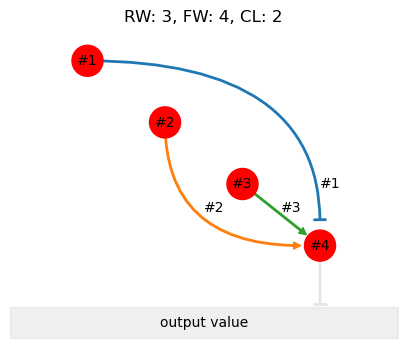

In [517]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.annotate("", [datdot.h[4 - 1], 1], [datdot.h[4 - 1], datdot.v[4 - 1]], arrowprops=a_aps[4], **arrconf)

ax.text(datdot.h[1 - 1], datdot.v[1 - 1], "#1", ha="center", va="center", size=10)
ax.text(datdot.h[2 - 1], datdot.v[2 - 1], "#2", ha="center", va="center", size=10)
ax.text(datdot.h[3 - 1], datdot.v[3 - 1], "#3", ha="center", va="center", size=10)
ax.text(datdot.h[4 - 1], datdot.v[4 - 1], "#4", ha="center", va="center", size=10)

# ax.text(datdot.h[1 - 1] -.3, 2, "1", ha="center", va="center", size=10, c="C0")
# ax.text(datdot.h[2 - 1], 2, "0", ha="center", va="center", size=10)
# ax.text(datdot.h[3 - 1] -.3, 2, "2", ha="center", va="center", size=10, c="C1")
# ax.text(datdot.h[4 - 1] -.3, 2, "3", ha="center", va="center", size=10, c="C2")
# ax.text(datdot.h[4 - 1] +.3, 2, "2", ha="center", va="center", size=10, c="C4")

ax.annotate("", *edge_pos[14], arrowprops=b_aps[14], **arrconf)
ax.annotate("", *edge_pos[24], arrowprops=b_aps[24], **arrconf)
ax.annotate("", *edge_pos[34], arrowprops=b_aps[34], **arrconf)

ax.text(*b_pos[14], "#1", ha="left", va="center", size=10)
ax.text(*b_pos[24], "#2", ha="left", va="bottom", size=10)
ax.text(*b_pos[34], "#3", ha="left", va="bottom", size=10)

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

ax.set_title("RW: 3, FW: 4, CL: 2")

fig.savefig(f"/home/jovyan/out/feat_rw_vs_fw_vs_cl", **kwarg_savefig)

In [317]:
datdot = pd.DataFrame({
    "h": [2, 4, 6, 8],
    "v": [9, 7, 5, 3],
    "c": [".9", ".9", ".9", ".9"]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: (datdot.h[2], datdot.v[1]),
    14: (datdot.h[3], datdot.v[2]),
    23: (datdot.h[1:3].mean(), datdot.v[1:3].mean()),
    24: (datdot.h[1:3].mean(), datdot.v[2:4].mean()),
    34: (datdot.h[2:4].mean(), datdot.v[2:4].mean()),
}

a_aps = {
    1: ap("C0"),
    2: ap2(".9"),
    3: ap("C0"),
    4: ap2("C1")
}

b_aps = {
    12: ap("C1"),
    13: app(1, "C0"),
    14: apn(1, ".9"),
    23: ap2(".9"),
    24: app(2, "C1"),
    34: ap("C2"),
}

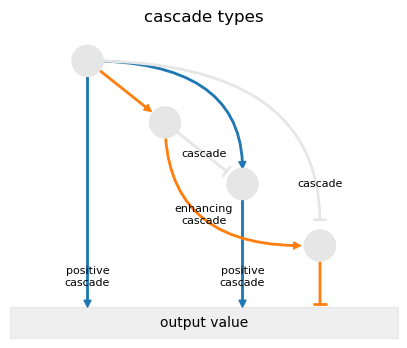

In [318]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(data=datdot, x="h", y="v", s=500, c="c")

ax.annotate("", [datdot.h[1 - 1], 1], [datdot.h[1 - 1], datdot.v[1 - 1]], arrowprops=a_aps[1], **arrconf)
# ax.annotate("", [datdot.h[2 - 1], 1], [datdot.h[2 - 1], datdot.v[2 - 1]], arrowprops=a_aps[2], **arrconf)
ax.annotate("", [datdot.h[3 - 1], 1], [datdot.h[3 - 1], datdot.v[3 - 1]], arrowprops=a_aps[3], **arrconf)
ax.annotate("", [datdot.h[4 - 1], 1], [datdot.h[4 - 1], datdot.v[4 - 1]], arrowprops=a_aps[4], **arrconf)

# ax.text(datdot.h[1 - 1], datdot.v[1 - 1], "0", ha="center", va="center", size=10)
# ax.text(datdot.h[2 - 1], datdot.v[2 - 1], "0", ha="center", va="center", size=10)
# ax.text(datdot.h[3 - 1], datdot.v[3 - 1], "0", ha="center", va="center", size=10)
# ax.text(datdot.h[4 - 1], datdot.v[4 - 1], "3", ha="center", va="center", size=10)

ax.text(datdot.h[1 - 1], 2, "positive\ncascade", ha="center", va="center", size=8)
# ax.text(datdot.h[2 - 1], 2, "0", ha="center", va="center", size=10)
ax.text(datdot.h[3 - 1], 2, "positive\ncascade", ha="center", va="center", size=8)
# ax.text(datdot.h[4 - 1], 2, "positive\ncascade", ha="center", va="center", size=8)
# ax.text(datdot.h[4 - 1] +.3, 2, "2", ha="center", va="center", size=10, c="C4")

ax.annotate("", *edge_pos[12], arrowprops=b_aps[12], **arrconf)
ax.annotate("", *edge_pos[13], arrowprops=b_aps[13], **arrconf)
ax.annotate("", *edge_pos[14], arrowprops=b_aps[14], **arrconf)
ax.annotate("", *edge_pos[23], arrowprops=b_aps[23], **arrconf)
ax.annotate("", *edge_pos[24], arrowprops=b_aps[24], **arrconf)
# ax.annotate("", *edge_pos[34], arrowprops=b_aps[34], **arrconf)

# ax.text(*b_pos[12], "0+1", ha="center", va="center", size=10)
# ax.text(*b_pos[13], "positive\ncascade", ha="center", va="center", size=8)
ax.text(*b_pos[14], "cascade", ha="center", va="center", size=8)
ax.text(*b_pos[23], "cascade", ha="center", va="center", size=8)
ax.text(*b_pos[24], "enhancing\ncascade", ha="center", va="center", size=8)
# ax.text(*b_pos[34], "0+1", ha="center", va="center", size=10)

ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)
ax.text(5, .5, "output value", ha="center", va="center")

ax.set_ylim([0, 10])
ax.set_xlim([0, 10])
ax.axis("off")

ax.set_title("cascade types")

fig.savefig(f"/home/jovyan/out/feat_cascade_types", **kwarg_savefig)

##### from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from ._abstract import AbstractSimulator
from doe_modules.simulation import AbstractSimulator
from doe_modules.design import DOE
from doe_modules.preferences import textcolor
from doe_modules.preferences.cmap import sparse

test4 = [plt.cm.nipy_spectral((i + 2)/6) for i in range(4)]

class Test4(AbstractSimulator):
    def __init__(
        self, 
        edge_assignsment: list,
        random_state: int = 0,
        model_id: int = "",
        kwarg_v: dict = dict(mean=1, sigma=.8),
        kwarg_a: dict = dict(mean=2, sigma=.3),
        kwarg_b: dict = dict(mean=1, sigma=.5)
    ):
        super().__init__(
            n_factor=4, random_state=random_state, cmap=test4, 
            name="Test" + model_id if model_id == "" else f"Test-{model_id}"
        )
        seeds = np.random.randint(0, 2**32, 3)
        np.random.seed(seeds[0])
        self.v = {
            i+1: vi for i, vi in enumerate(
                np.random.lognormal(**kwarg_v, size=self.n_factor)
            )
        }
        np.random.seed(seeds[1])
        self.a = {
            i: sign * a for i, a, sign in zip(
                np.arange(1, self.n_factor + 1).astype(int),
                np.random.lognormal(**kwarg_a, size=self.n_factor),
                edge_assignsment[:self.n_factor]
            )
        }
        np.random.seed(seeds[2])
        self.b = {
            i: sign * b for i, b, sign in zip(
                [12, 13, 14, 23, 24, 34],
                np.random.lognormal(**kwarg_b, size=6),
                edge_assignsment[self.n_factor:]
            )
        }

    def run(
        self, 
        design_array, 
        random_state: int = 0,
        kwarg_err: dict = dict(loc=0, scale=1),
    ):
        super().run(design_array=design_array, random_state=random_state)
        e = np.random.normal(**kwarg_err, size=6)
        f = lambda x: max(0, x)
        c = self.c

        x1 = f(c[1] * (self.v[1] + e[1]))
        x2 = f(c[2] * (self.v[2] + self.b[12] * x1 + e[2]))
        x3 = f(c[3] * (self.v[3] + self.b[13] * x1 + self.b[23] * x2 + e[3]))
        x4 = f(c[4] * (self.v[4] + self.b[14] * x1 + self.b[24] * x2 + self.b[34] * x3 + e[4]))
        self.c = c
        self.x = {i+1: xi for i, xi in enumerate([x1, x2, x3, x4])}
        self.y = sum([self.a[i + 1] * self.x[i + 1] for i in range(self.n_factor)]) + e[0]
        return self.y
    

    def plot(
        self,
        ax: plt.Axes
    ):
        ax.fill_between([0, 10], [0, 0], [1, 1], color=".7", alpha=.2)

        datdot = pd.DataFrame({
            "name": [
                f"X{i + 1}" if self.x is None else round(self.x[i + 1], 2) for i in range(self.n_factor)
            ],
            "h": [2, 4, 6, 8],
            "v": [9, 7, 5, 3],
            "c": [
               ".7" if self.x is not None and self.x[i + 1] == 0 else self.cmap[i] for i in range(self.n_factor)
            ],
            "alpha": [
               .2 if self.x is not None and self.x[i + 1] == 0 else 1 for i in range(self.n_factor)
            ],
        })

        ax.scatter(data=datdot, x="h", y="v", s=500, color="c", alpha=datdot.alpha)
        ap = lambda n: dict(
            shrink=0, width=1, headwidth=5, 
            headlength=5, connectionstyle="arc3",
            facecolor=datdot.c[n - 1], edgecolor=datdot.c[n - 1],
            alpha=datdot.alpha[n - 1]
        )
        
        ap2 = lambda n: dict(
            arrowstyle="|-|", connectionstyle="arc3",
            facecolor=datdot.c[n - 1], edgecolor=datdot.c[n - 1],
            linewidth=2, mutation_scale=4,
            alpha=datdot.alpha[n - 1]
        )
        
        angleA = lambda n: [0, -90, 0, -45][n - 1]
        angleB = lambda n: [90, 180, 105, 120][n - 1]
        
        app = lambda n: dict(
            shrink=0, width=1, headwidth=5, 
            headlength=5, 
            connectionstyle=f"angle3, angleA={angleA(n)}, angleB={angleB(n)}",
            facecolor=datdot.c[n - 1], edgecolor=datdot.c[n - 1],
            alpha=datdot.alpha[n - 1]
        )
        
        apn = lambda n: dict(
            arrowstyle="|-|", connectionstyle=f"angle3, angleA={angleA(n)}, angleB={angleB(n)}",
            facecolor=datdot.c[n - 1], edgecolor=datdot.c[n - 1],
            linewidth=2, mutation_scale=4,
            alpha=datdot.alpha[n - 1]
        )

        arrconf=dict(ha="center", va="center", zorder=-10)
        
        edge_pos = {
            12: ([datdot.h[1] - .5 / np.sqrt(2), datdot.v[1] + .5 / np.sqrt(2)], [datdot.h[0], datdot.v[0]]),
            13: ([datdot.h[2], datdot.v[2] + .5], [datdot.h[0], datdot.v[0]]),
            14: ([datdot.h[3], datdot.v[3] + .75], [datdot.h[0], datdot.v[0]]),
            23: ([datdot.h[2] - .5 / np.sqrt(2), datdot.v[2] + .5 / np.sqrt(2)], [datdot.h[1], datdot.v[1]]),
            24: ([datdot.h[3] - .5, datdot.v[3]], [datdot.h[1], datdot.v[1]]),
            34: ([datdot.h[3] - .5 / np.sqrt(2), datdot.v[3] + .5 / np.sqrt(2)], [datdot.h[2], datdot.v[2]]),
        }
        b_pos = {
            12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
            13: (datdot.h[2], datdot.v[1]),
            14: (datdot.h[3], datdot.v[2]),
            23: (datdot.h[1:3].mean(), datdot.v[1:3].mean()),
            24: (datdot.h[1:3].mean(), datdot.v[2:4].mean()),
            34: (datdot.h[2:4].mean(), datdot.v[2:4].mean()),
        }
        
        a_aps = {
            k: ap(k) if a >=0 else ap2(k) for k, a in self.a.items()
        }

        b_aps = {
            12: ap(1) if self.b[12] >=0 else ap2(1),
            13: app(1) if self.b[13] >=0 else apn(1),
            14: app(1) if self.b[14] >=0 else apn(1),
            23: ap(2) if self.b[23] >=0 else ap2(2),
            24: app(2) if self.b[24] >=0 else apn(2),
            34: ap(3) if self.b[34] >=0 else ap2(3),
        }
        
        for idx, a in self.a.items():
            if a != 0:
                ax.annotate("", [datdot.h[idx - 1], 1], [datdot.h[idx - 1], datdot.v[idx - 1]], arrowprops=a_aps[idx], **arrconf)
                ax.text(
                    datdot.h[idx - 1], 2,
                    "" if datdot.name[int(str(idx)[0]) - 1] in [f"X{int(str(idx)[0])}", 0.0] else r"$\times$" + f"{a.round(2)}",
                    ha="center", va="center", size=6
                )
        
        for idx, b in self.b.items():
            if b != 0:
                ax.annotate("", *edge_pos[idx], arrowprops=b_aps[idx], **arrconf)
                ax.text(
                    *b_pos[idx],
                    "" if datdot.name[int(str(idx)[0]) - 1] in [f"X{int(str(idx)[0])}", 0.0] else r"$\times$" + f"{b.round(2)}",
                    ha="center", va="center", size=6
                )

        for i in range(len(datdot)):
            ax.text(
                *datdot.iloc[i, 1:3], datdot.iloc[i, 0], ha="center", va="center",
                size="medium" if self.x is None else 7,
                c=textcolor(datdot.c[i])
            )

        
        if self.c is not None:
            for n, c in self.c.items():
                ax.scatter(
                    *{i + 1: (h, v) for i, h, v in zip(range(9), datdot.h, datdot.v)}[n],
                    marker="x", s=300, color="r"
                ) if c == 0 else None

        ax.text(5, .5, "output value" if self.y is None else round(self.y, 2), ha="center", va="center")

        ax.set_ylim([0, 10])
        ax.set_xlim([0, 10])

        ax.axis("off")
        return None


    def simulate(
        self,
        design: DOE = None,
        n_rep: int = 1,
        random_state: int = 0,
        plot: bool = False,
        ax: np.ndarray = None,
        titles: List[str] = None,
        model_kwargs: dict = {},
        **kwargs
    ):
        super().simulate(
            design=design, n_rep=n_rep,
            random_state=random_state,
            plot=plot, ax=ax, 
            titles=titles,
            model_kwargs=model_kwargs,
            **kwargs
        )


    def scatterview(
        self,
        ax: plt.Axes
    ):
        super().scatterview(ax=ax)

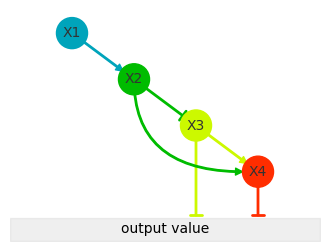

In [447]:
fig, ax = plt.subplots(figsize=(4, 3))
model = Test4(edges[26846])
model.plot(ax)

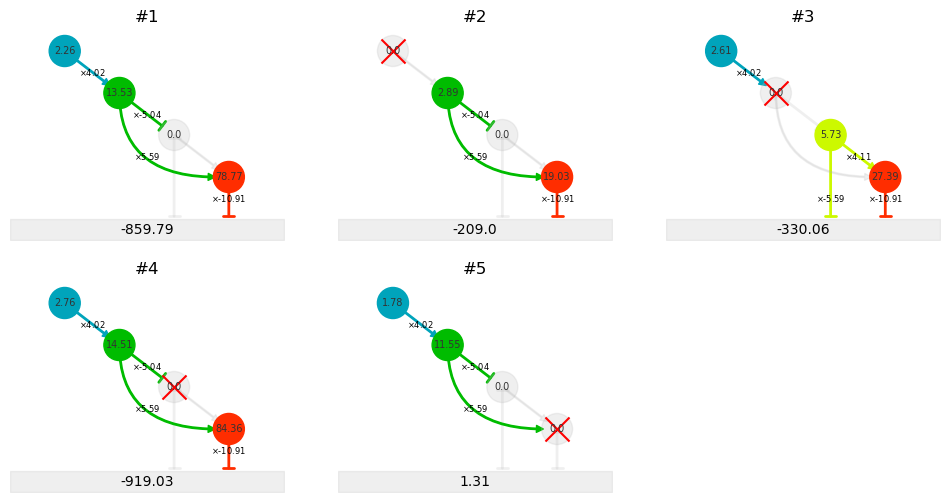

In [449]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
model = models[26846]

model.simulate(
    design=CLOO, plot=True, ax=ax
)

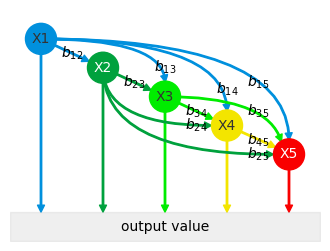

In [251]:
fig, ax = plt.subplots(figsize=(4, 3))
model = models[-1]
model.plot(ax)

datdot = pd.DataFrame({
    "h": [1, 3, 5, 7, 9],
    "v": [7, 6, 5, 4, 3]
})

b_pos = {
    12: (datdot.h[0:2].mean(), datdot.v[0:2].mean()),
    13: (datdot.h[2], datdot.v[2] + 1),
    14: (datdot.h[3], datdot.v[3] + 1.25),
    15: (datdot.h[3:].mean(), datdot.v[3:].mean() + 2),
    23: (datdot.h[1:3].mean(), datdot.v[1:3].mean()),
    24: (datdot.h[3] - 1, datdot.v[3]),
    25: (datdot.h[4] - 1, datdot.v[4]),
    34: (datdot.h[2:4].mean(), datdot.v[2:4].mean()),
    35: (datdot.h[3:].mean(), datdot.v[3:].mean() + 1),
    45: (datdot.h[3:].mean(), datdot.v[3:].mean()),
}

for idx, b in b_pos.items():
    ax.text(
        *b_pos[idx], r"$b_{" + str(idx) + "}$",
        ha="center", va="center", size=10
    )

fig.savefig(f"/home/jovyan/out/prototype_models", **kwarg_savefig)

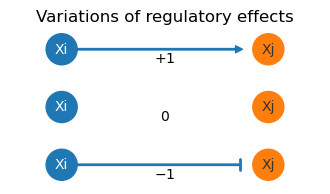

In [450]:
fig, ax = plt.subplots(figsize=(4, 2))

datdot = pd.DataFrame({
    "name": ["Xi", "Xj"] * 3,
    "h": [1, 5, 1, 5, 1, 5],
    "v": [9, 9, 6, 6, 3, 3],
    "c": [plt.cm.tab10(0), plt.cm.tab10(1)] * 3
})

ap = lambda n: dict(
    shrink=0, width=1, headwidth=5, 
    headlength=5, connectionstyle="arc3",
    facecolor=datdot.c[n - 1], edgecolor=datdot.c[n - 1]
)
        
ap2 = lambda n: dict(
    arrowstyle="|-|", connectionstyle="arc3",
    facecolor=datdot.c[n - 1], edgecolor=datdot.c[n - 1],
    linewidth=2, mutation_scale=4,
)

arrconf=dict(ha="center", va="center", zorder=-10)

ax.scatter(data=datdot, x="h", y="v", s=500, color="c")

ax.annotate("", [4.5, 9], [1, 9], arrowprops=ap(1), **arrconf)
ax.annotate("", [4.5, 3], [1, 3], arrowprops=ap2(1), **arrconf)

for i, name in enumerate(datdot.name):
    ax.text(
        datdot.h[i], datdot.v[i], name, 
        ha="center", va="center", size="medium",
        c=textcolor(datdot.c[i])
    )

ax.set_ylim([2, 10])
ax.set_xlim([0, 6])
ax.axis("off")

ax.text(3, 8.5, r"$+1$", ha="center", va="center", size=10)
ax.text(3, 5.5, r"$0$", ha="center", va="center", size=10)
ax.text(3, 2.5, r"$-1$", ha="center", va="center", size=10)

ax.set_title("Variations of regulatory effects")

fig.savefig(f"/home/jovyan/out/prototype_models_edges", **kwarg_savefig)

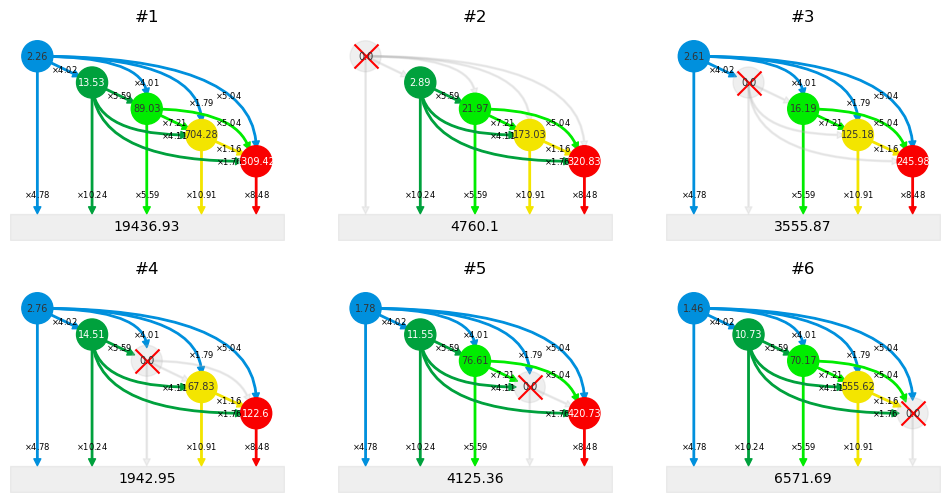

In [173]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

model.simulate(
    design=CLOO, plot=True, ax=ax
)

In [174]:
model.simulate(design=CLOO, n_rep=3)

In [175]:
from doe_modules.plot import bio_multicomp

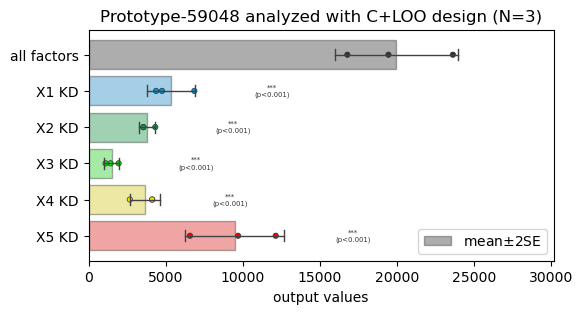

In [176]:
fig, ax = plt.subplots(figsize=(6, 3))
bio_multicomp(model, cmap=model.cmap, ax=ax, text_kwargs={"size": 5}, xscales=[4, 1.2], jitter_ratio=.2)

In [78]:
top = np.array([
    [0, 0, 0, 0, 0],
    [0, 2, 0, 3, 0],
    [0, 0, 0, 0, 0],
    [0, 4, 0, 5, 0],
    [0, 0, 0, 0, 0]
]).ravel()

In [239]:
from doe_modules.preferences import kwarg_savefig

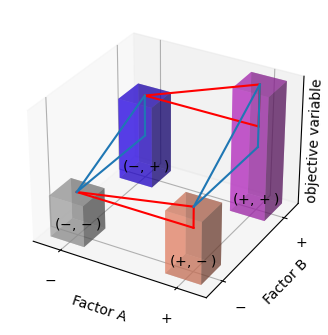

In [236]:
fig = plt.figure(figsize=(4, 4), facecolor="w")
ax = fig.add_subplot(111, projection="3d")

a = 2
b = 3
c = 4
d = 6

width = depth = .3
center = depth / 2

ax.bar3d(0, 0, 0, width, depth, a, shade=True, alpha=.5, color=".7")
ax.bar3d(1, 0, 0, width, depth, b, shade=True, alpha=.5, color=plt.cm.gnuplot2(.7))
ax.bar3d(0, 1, 0, width, depth, c, shade=True, alpha=.5, color=plt.cm.gnuplot2(.3))
ax.bar3d(1, 1, 0, width, depth, d, shade=True, alpha=.5, color=plt.cm.gnuplot2(.5))


ax.plot([0 + center, 1 + center], [0 + center, 0 + center], [a, b], c="r", zorder=10)
ax.plot([0 + center, 1 + center], [0 + center, 0 + center], [a, a], c="r", zorder=10)
ax.plot([1 + center, 1 + center], [0 + center, 0 + center], [a, b], c="r", zorder=10)
ax.plot([0 + center, 1 + center], [1 + center, 1 + center], [c, d], c="r", zorder=10)
ax.plot([0 + center, 1 + center], [1 + center, 1 + center], [c, c], c="r", zorder=10)
ax.plot([1 + center, 1 + center], [1 + center, 1 + center], [c, d], c="r", zorder=10)

ax.plot([0 + center, 0 + center], [0 + center, 1 + center], [a, c], c="C0", zorder=10)
ax.plot([0 + center, 0 + center], [0 + center, 1 + center], [a, a], c="C0", zorder=10)
ax.plot([0 + center, 0 + center], [1 + center, 1 + center], [a, c], c="C0", zorder=10)
ax.plot([1 + center, 1 + center], [0 + center, 1 + center], [b, d], c="C0", zorder=10)
ax.plot([1 + center, 1 + center], [0 + center, 1 + center], [b, b], c="C0", zorder=10)
ax.plot([1 + center, 1 + center], [1 + center, 1 + center], [b, d], c="C0", zorder=10)
# ax.plot([1 + center, 0 + center], [0 + center, 1 + center], [b, c], c=".5", zorder=10)

ax.set_xticks([0 + center, 1 + center], ["$-$", "$+$"])
ax.set_yticks([0 + center, 1 + center], ["$-$", "$+$"])
ax.set_zticks([], [])
ax.set_xlabel("Factor A", labelpad=-1)
ax.set_ylabel("Factor B", labelpad=0)
ax.set_zlabel("objective variable", labelpad=-15)

ax.text(0 + center, 0 + center, 0, "$(-,-)$", zorder=100, ha="center", va="bottom")
ax.text(1 + center, 0 + center, 0, "$(+,-)$", zorder=100, ha="center", va="bottom")
ax.text(0 + center, 1 + center, 0, "$(-,+)$", zorder=100, ha="center", va="bottom")
ax.text(1 + center, 1 + center, 0, "$(+,+)$", zorder=100, ha="center", va="bottom")

plt.show()

fig.savefig(f"/home/jovyan/out/multicomp_vs_anova", **kwarg_savefig)

In [210]:
test5 = [plt.cm.gnuplot2((i + 2)/7) for i in range(5)]

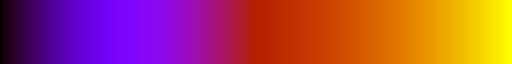

In [211]:
plt.cm.gnuplot

In [1]:
from scipy.stats import f

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [41]:
from doe_modules.design import PlackettBurman, CLOO

In [5]:
import statsmodels.api as sm

In [43]:
f.ppf(0.95, 1, 26)

4.2252012731274835

In [44]:
f.ppf(0.95, 1, 33)

4.139252495555367

In [23]:
import seaborn as sns

In [24]:
from doe_modules.preferences import kwarg_savefig, outputdir

In [25]:
cmap = sns.color_palette("husl", 2)

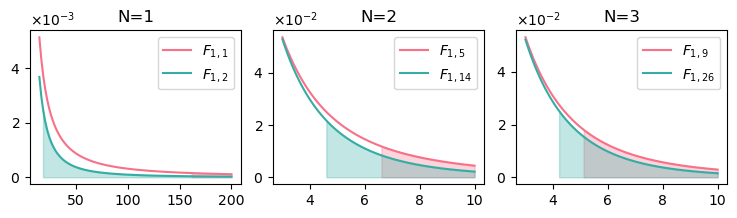

In [40]:
N_max = 3

fig, ax = plt.subplots(1, N_max, figsize=(3 * N_max, 2))
plt.subplots_adjust(wspace=.15)

plot_f = lambda dfn, dfd, x_min, x_max: (
    np.linspace(x_min, x_max, 100),
    f.pdf(np.linspace(x_min, x_max, 100), dfn, dfd)
)

fill_f = lambda dfn, dfd, alpha, x_max: (
    np.linspace(f.ppf(alpha, dfn, dfd), x_max, 100),
    f.pdf(np.linspace(f.ppf(alpha, dfn, dfd), x_max, 100), dfn, dfd)
)

phi = lambda mat: len(mat) - np.linalg.matrix_rank(mat)

for i, a in enumerate(ax.ravel()):
    N = i + 1
    X = lambda n: np.vstack([sm.add_constant(PlackettBurman().get_exmatrix(n)().values)] * N)
    x_min, x_max = (3, 10) if N > 1 else (15, 200)
    a.plot(*plot_f(1, phi(X(2)), x_min, x_max), label="$F_{1," + f"{phi(X(2))}" + "}$", color=cmap[0])
    a.plot(*plot_f(1, phi(X(9)), x_min, x_max), label="$F_{1," + f"{phi(X(9))}" + "}$", color=cmap[1])

    a.fill_between(*fill_f(1, phi(X(2)), 0.95, x_max), alpha=.3, color=cmap[0])
    a.fill_between(*fill_f(1, phi(X(9)), 0.95, x_max), alpha=.3, color=cmap[1])

    a.set_ylim(a.get_ylim())
    a.ticklabel_format(style="sci", axis="y", scilimits=(-2, -3), useMathText=True)
    a.set_title(f"N={N}")
    a.legend()
    
fig.savefig(f"{outputdir}/f_distribution", **kwarg_savefig)

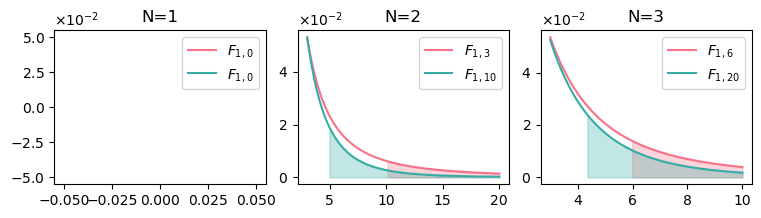

In [43]:
N_max = 3

fig, ax = plt.subplots(1, N_max, figsize=(3 * N_max, 2))
plt.subplots_adjust(wspace=.15)

plot_f = lambda dfn, dfd, x_min, x_max: (
    np.linspace(x_min, x_max, 100),
    f.pdf(np.linspace(x_min, x_max, 100), dfn, dfd)
)

fill_f = lambda dfn, dfd, alpha, x_max: (
    np.linspace(f.ppf(alpha, dfn, dfd), x_max, 100),
    f.pdf(np.linspace(f.ppf(alpha, dfn, dfd), x_max, 100), dfn, dfd)
)

phi = lambda mat: len(mat) - np.linalg.matrix_rank(mat)

for i, a in enumerate(ax.ravel()):
    N = i + 1
    X = lambda n: np.vstack([sm.add_constant(CLOO().get_exmatrix(n)().values)] * N)
    x_min, x_max = (3, 10) if N > 2 else (3, 20)
    a.plot(*plot_f(1, phi(X(2)), x_min, x_max), label="$F_{1," + f"{phi(X(2))}" + "}$", color=cmap[0])
    a.plot(*plot_f(1, phi(X(9)), x_min, x_max), label="$F_{1," + f"{phi(X(9))}" + "}$", color=cmap[1])

    a.fill_between(*fill_f(1, phi(X(2)), 0.95, x_max), alpha=.3, color=cmap[0])
    a.fill_between(*fill_f(1, phi(X(9)), 0.95, x_max), alpha=.3, color=cmap[1])

    a.set_ylim(a.get_ylim())
    a.ticklabel_format(style="sci", axis="y", scilimits=(-2, -3), useMathText=True)
    a.set_title(f"N={N}")
    a.legend()
    
# fig.savefig(f"{outputdir}/f_distribution", **kwarg_savefig)

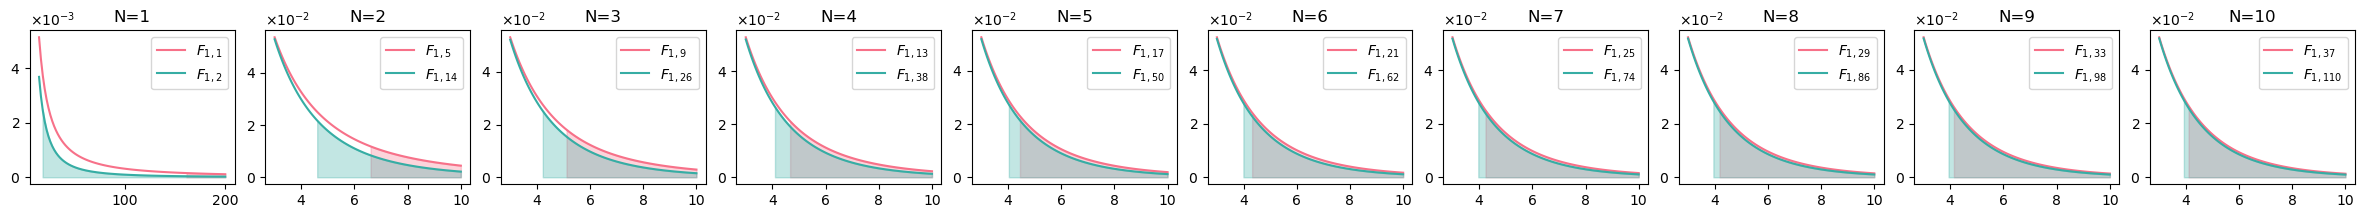

In [39]:
N_max = 10

fig, ax = plt.subplots(1, N_max, figsize=(3 * N_max, 2))
plt.subplots_adjust(wspace=.15)

plot_f = lambda dfn, dfd, x_min, x_max: (
    np.linspace(x_min, x_max, 100),
    f.pdf(np.linspace(x_min, x_max, 100), dfn, dfd)
)

fill_f = lambda dfn, dfd, alpha, x_max: (
    np.linspace(f.ppf(alpha, dfn, dfd), x_max, 100),
    f.pdf(np.linspace(f.ppf(alpha, dfn, dfd), x_max, 100), dfn, dfd)
)

phi = lambda mat: len(mat) - np.linalg.matrix_rank(mat)

for i, a in enumerate(ax.ravel()):
    N = i + 1
    X = lambda n: np.vstack([sm.add_constant(PlackettBurman().get_exmatrix(n)().values)] * N)
    x_min, x_max = (3, 10) if N > 1 else (15, 200)
    a.plot(*plot_f(1, phi(X(2)), x_min, x_max), label="$F_{1," + f"{phi(X(2))}" + "}$", color=cmap[0])
    a.plot(*plot_f(1, phi(X(9)), x_min, x_max), label="$F_{1," + f"{phi(X(9))}" + "}$", color=cmap[1])

    a.fill_between(*fill_f(1, phi(X(2)), 0.95, x_max), alpha=.3, color=cmap[0])
    a.fill_between(*fill_f(1, phi(X(9)), 0.95, x_max), alpha=.3, color=cmap[1])

    a.set_ylim(a.get_ylim())
    a.ticklabel_format(style="sci", axis="y", scilimits=(-2, -3), useMathText=True)
    a.set_title(f"N={N}")
    a.legend()
    
# fig.savefig(f"{outputdir}/f_distribution", **kwarg_savefig)

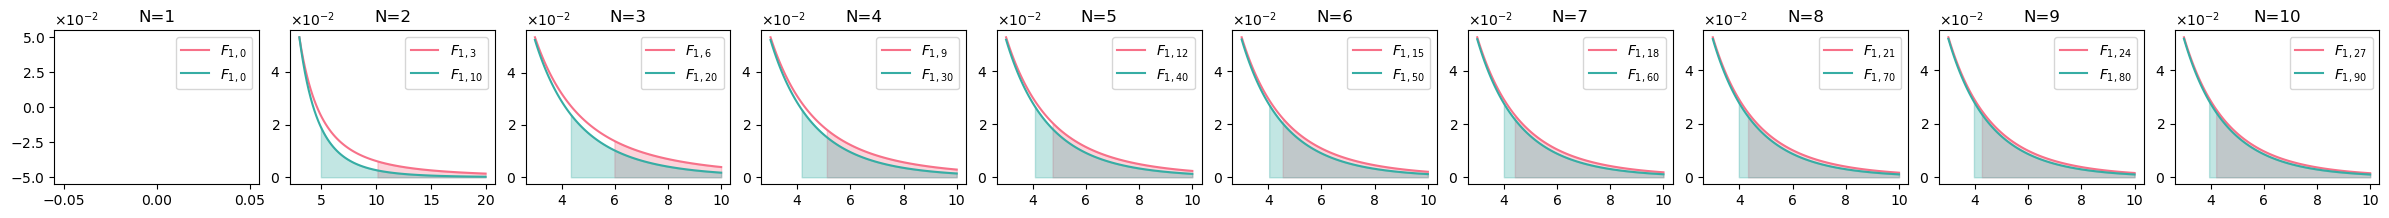

In [44]:
N_max = 10

fig, ax = plt.subplots(1, N_max, figsize=(3 * N_max, 2))
plt.subplots_adjust(wspace=.15)

plot_f = lambda dfn, dfd, x_min, x_max: (
    np.linspace(x_min, x_max, 100),
    f.pdf(np.linspace(x_min, x_max, 100), dfn, dfd)
)

fill_f = lambda dfn, dfd, alpha, x_max: (
    np.linspace(f.ppf(alpha, dfn, dfd), x_max, 100),
    f.pdf(np.linspace(f.ppf(alpha, dfn, dfd), x_max, 100), dfn, dfd)
)

phi = lambda mat: len(mat) - np.linalg.matrix_rank(mat)

for i, a in enumerate(ax.ravel()):
    N = i + 1
    X = lambda n: np.vstack([sm.add_constant(CLOO().get_exmatrix(n)().values)] * N)
    x_min, x_max = (3, 10) if N > 2 else (3, 20)
    a.plot(*plot_f(1, phi(X(2)), x_min, x_max), label="$F_{1," + f"{phi(X(2))}" + "}$", color=cmap[0])
    a.plot(*plot_f(1, phi(X(9)), x_min, x_max), label="$F_{1," + f"{phi(X(9))}" + "}$", color=cmap[1])

    a.fill_between(*fill_f(1, phi(X(2)), 0.95, x_max), alpha=.3, color=cmap[0])
    a.fill_between(*fill_f(1, phi(X(9)), 0.95, x_max), alpha=.3, color=cmap[1])

    a.set_ylim(a.get_ylim())
    a.ticklabel_format(style="sci", axis="y", scilimits=(-2, -3), useMathText=True)
    a.set_title(f"N={N}")
    a.legend()
    
# fig.savefig(f"{outputdir}/f_distribution", **kwarg_savefig)

In [50]:
phi = lambda mat: len(mat) - np.linalg.matrix_rank(mat)
diff = lambda mat, mat_eff: f.ppf(0.95, 1, phi(mat_eff)) - f.ppf(0.95, 1, phi(mat))

X_cloo = lambda n, N: np.vstack([sm.add_constant(CLOO().get_exmatrix(n)().values)] * N)
X_pb = lambda n, N: np.vstack([sm.add_constant(PlackettBurman().get_exmatrix(n)().values)] * N)

x_range = np.arange(1, 11)

y_cloo = np.vectorize(lambda N: diff(X_cloo(9, N), X_cloo(2, N)))(x_range)
y_pb = np.vectorize(lambda N: diff(X_pb(9, N), X_pb(2, N)))(x_range)

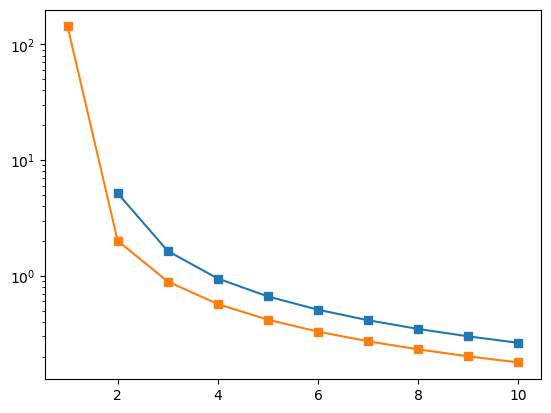

In [61]:
fig, ax = plt.subplots()

ax.plot(x_range, y_cloo, marker="s")
ax.plot(x_range, y_pb, marker="s")
ax.set_yscale("log")

In [57]:
def build_5x5_matrix(args: dict):
    args = {**args, **{(i, i): 1 for i in range(5)}}
    return np.array([
        [args[(i, j)] if (i, j) in args else 0 for j in range(5)] for i in range(5)
    ])

In [58]:
build_5x5_matrix({(1, 2): 5})

array([[1, 0, 0, 0, 0],
       [0, 1, 5, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

In [74]:
relu = np.vectorize(lambda x: max(0, x))

In [76]:
relu(build_5x5_matrix({(1, 2): 5}))

array([[1, 0, 0, 0, 0],
       [0, 1, 5, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

In [162]:
Relu(1, 1) * (-np.eye(5)) @ (Relu(1, 1) * (-np.eye(5)))

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [160]:
class Relu:
    def __init__(self, row, col):
        self.row = row
        self.col = col

    def __mul__(self, matrix):
        return np.array([
            [
                max(0, el) if self.row == ir and self.col == ic else el for ic, el in enumerate(row)
            ] for ir, row in enumerate(matrix)
        ])

In [64]:
def edges(
    b12, b13, b14, b15,
    b23, b24, b25, 
    b34, b35, 
    b45
):
    return lambda arr: Relu(3, 3) * (
        Relu(2, 2) * (
            Relu(1, 1) * (
                Relu(0, 0) * (
                    arr @ build_5x5_matrix(
                        {(0, i + 1): v for i, v in enumerate([b12, b13, b14, b15])}
                    )
                ) @ build_5x5_matrix(
                    {(1, i + 2): v for i, v in enumerate([b23, b24, b25])}
                )
            ) @ build_5x5_matrix(
                {(2, i + 3): v for i, v in enumerate([b34, b35])}
            )
        ) @ build_5x5_matrix(
        {(3, i + 4): v for i, v in enumerate([b45])}
    )





Relu * (arr @ build_5x5_matrix({(0, i + 1): v for i, v in enumerate([b12, b13, b14, b15])}))
         @ build_5x5_matrix(
            {(1, i + 2): v for i, v in enumerate([b23, b24, b25])}
        )
     @ build_5x5_matrix(
        {(2, i + 3): v for i, v in enumerate([b34, b35])}
    ) @ build_5x5_matrix(
        {(3, i + 4): v for i, v in enumerate([b45])}
    )

In [ ]:
def sim_generator(
)

In [73]:
(
    np.array([[1, 2, 3, 4, 5]]) @ edges(*range(10)) @ np.array([[1] for v in range(5)])
).item()

1131